In [11]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length "{length}" bytes'.format(name=fn, length = len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving brain-tumor-detection.zip to brain-tumor-detection.zip
User uploaded file "brain-tumor-detection.zip" with length "15828590" bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [7]:
!pwd

/content


In [5]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-detection.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Unzipped")


Unzipped


In [6]:
# Import required libraries
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [7]:
!pwd

/content/no


In [23]:
os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img, (224,224))
  X.append(img)
  y.append(1)
os.chdir('/content/no')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img, (224,224))
  X.append(img)
  y.append(0)
# for i in range(0,99):
#   y.append('N')


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [24]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print("Shape of image in X train = ", X_train[0].shape)
print("Shape of image in X test = ", X_test[0].shape)

Shape of image in X train =  (224, 224, 3)
Shape of image in X test =  (224, 224, 3)


In [25]:
import numpy as np
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [26]:
print("X_train shape = ",X_train.shape)
print("X_test shape = ",X_test.shape)
print("y_train shape = ",y_train.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (169, 224, 224, 3)
X_test shape =  (84, 224, 224, 3)
y_train shape =  (169, 2)
y_test shape =  (84, 2)


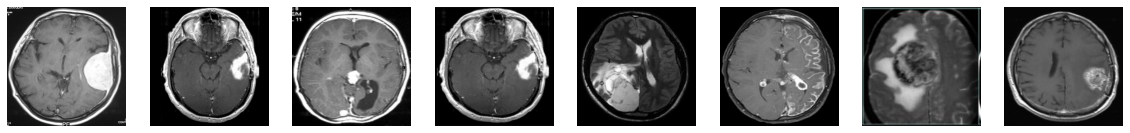

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')
plt.show()

In [28]:
from keras.applications.resnet import ResNet50 
from keras import Model, layers
from keras.optimizers import SGD
img_rows, img_cols = 224,224

conv_base = ResNet50(
    include_top=False,
    weights='imagenet',input_shape = (img_rows, img_cols,3))

for layer in conv_base.layers:
    layer.trainable = False

#Print layers
for (i,layer) in enumerate(conv_base.layers):
  print(str(i) + " "+layer.__class__.__name__, layer.trainable)



0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [29]:
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras import regularizers
def lw(bottom_model, num_classes):
  # Create the top of the model which was removed. 
  # This will be placed on top of the model
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
  top_model = Dense(num_classes, activation = 'softmax')(top_model)
  return top_model


In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

num_classes = 2

FC_Head = lw(conv_base, num_classes)
model = Model(inputs=conv_base.input, outputs = FC_Head)
#model = Model(inputs=vgg16.input, outputs = FC_Head)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [31]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [32]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [33]:
history = model.fit(X_train, y_train, epochs = 5, validation_data=(X_test,y_test), verbose = 1, initial_epoch=0)

Epoch 1/5
6/6 [==============================] - 59s 9s/step - loss: 3.4345 - accuracy: 0.6391 - val_loss: 2.4014 - val_accuracy: 0.6429
Epoch 2/5
6/6 [==============================] - 51s 9s/step - loss: 2.2096 - accuracy: 0.7456 - val_loss: 2.0833 - val_accuracy: 0.7976
Epoch 3/5
6/6 [==============================] - 46s 8s/step - loss: 1.8905 - accuracy: 0.8580 - val_loss: 1.8114 - val_accuracy: 0.8929
Epoch 4/5
6/6 [==============================] - 46s 8s/step - loss: 1.6594 - accuracy: 0.9053 - val_loss: 1.7118 - val_accuracy: 0.8571
Epoch 5/5
6/6 [==============================] - 44s 8s/step - loss: 1.4539 - accuracy: 0.9053 - val_loss: 1.6437 - val_accuracy: 0.8452


In [36]:
model_json = model.to_json()
with open("resnet50_model.json", "w") as json_file:
    json_file.write(model_json)


In [37]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("resnet50_model.h5")

In [38]:
model.save('/content/resnet50_model', save_format = 'h5')

In [39]:
# It can be used to reconstruct the model identically.
from tensorflow import keras
reconstructed_model = keras.models.load_model("resnet50_model.h5")

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = reconstructed_model.predict(X_test)
#ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print('Confusion_Matrix:\n',confusion_matrix(y_test, y_pred))
print('\nClassification_report:\n',classification_report(y_pred,y_test))

3/3 [==============================] - 24s 8s/step
Confusion_Matrix:
 [[21 12]
 [ 1 50]]

Classification_report:
               precision    recall  f1-score   support

           0       0.64      0.95      0.76        22
           1       0.98      0.81      0.88        62

    accuracy                           0.85        84
   macro avg       0.81      0.88      0.82        84
weighted avg       0.89      0.85      0.85        84



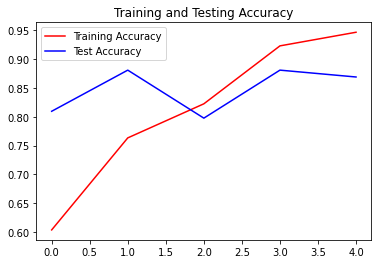

<Figure size 432x288 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Test Accuracy')

plt.title("Training and Testing Accuracy")

plt.legend(loc=0)

plt.figure()

plt.show()